In [1]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from classifier.classical_classifiers import RFClassifier,SVM
from classifier.MLP import MLPMutliclass16S
import pandas as pd

Using TensorFlow backend.
/home/nuria/.local/share/virtualenvs/MicroPheno-F70P6HaP/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nuria/.local/share/virtualenvs/MicroPheno-F70P6HaP/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nuria/.local/share/virtualenvs/MicroPheno-F70P6HaP/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np

# Crohn's Disease

### 3. Classifers

In [2]:
# labels
labels=['Not-CD', 'CD'] # clase negativa, clase positiva

#### Classical Classifiers

In [3]:
# CARGAR O ARQUIVO DE REPRESENTACIÓN K-MERS QUE MELLORES RESULTADOS DESE E OS RESULTADOS DE CLASIFICACIÓN REAIS

# X = matriz con datos:  (nº mostra, nº k-mers da secuencia) Abundancia relativa do k-mer na secuencia
#     en total temos 1359 mostras e 4096 6-mers
# Y = lista de resultados reais:  (CD = 1 , not CD = 0)
X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/dataset_6-mers_rate_complete1359_seq_5000.npz')
#X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/PRUEBA-dataset_6-mers_rate_complete1359_seq_5000.npz')
Y=FileUtility.load_list('../../crohns_disease/datasets/labels_disease_complete1359.txt')
#Y=FileUtility.load_list('../../crohns_disease/datasets/PRUEBA-labels_disease_complete1359.txt')

# vemos os datos de X
#dataset=pd.read_csv("../../crohns_disease/datasets/PRUEBA-dataset_6-mers_rate_complete1359_seq_5000.csv")
#dataset

In [ ]:
# CREAR E ENTRENAR OS CLASIFICADORES E GARDAR OS RESULTADOS 
##### (results containing the best parameter, confusion matrix, best estimator)

################ Random Forest ################
MRF = RFClassifier(X, Y, labels)
MRF.tune_and_eval('../../crohns_disease/results/RFclassifier', n_fold=10, n_jobs=None)
#MRF.tune_and_eval('../../crohns_disease/results/RFclassifier-PRUEBA', n_fold=2, n_jobs=6)

In [ ]:
################ Support Vector Machine ################
MSVM = SVM(X, Y, labels)
MSVM.tune_and_eval('../../crohns_disease/results/SVMclassifier', n_fold=10, n_jobs=None)
#MSVM.tune_and_eval('../../crohns_disease/results/SVMclassifier-PRUEBA', n_fold=2, n_jobs=6)

#### DNN Classifier

In [3]:
# CARGAR O ARQUIVO DE REPRESENTACIÓN K-MERS QUE MELLORES RESULTADOS DESE E OS RESULTADOS DE CLASIFICACIÓN REAIS

#X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/dataset_6-mers_rate_complete1359_seq_5000.npz').toarray()
X=FileUtility.load_sparse_csr('../../crohns_disease/datasets/PRUEBA-dataset_6-mers_rate_complete1359_seq_5000.npz').toarray()
#Y=FileUtility.load_list('../../crohns_disease/datasets/labels_disease_complete1359.txt')
Y=FileUtility.load_list('../../crohns_disease/datasets/PRUEBA-labels_disease_complete1359.txt')

In [ ]:
# CREAR E ENTRENAR OS CLASIFICADORES E GARDAR OS RESULTADOS

################ Multilayer Perceptron  ################
MLP=MLPMutliclass16S(X, Y, labels, model_strct='mlp', model_arch=[1024,0.2,512,0.2,256,0.1,128,8])
MLP.tune_and_eval('../../crohns_disease/results/MLPclassifier', gpu_dev='1', n_fold=10, epochs=100, batch_size=1000)
#MLP.tune_and_eval('../../crohns_disease/results/MLPclassifier-PRUEBA', gpu_dev='1', n_fold=2, epochs=1, batch_size=6)

In [ ]:
#DNN.make_weights('../../crohns_disease/results/MLPclassifier', epochs=100, batch_size=1000, f1mac=0.68)

In [ ]:
#X_new=DNNMutliclass16S.make_activation_function(X, '../../crohns_disease/results-PRUEBA/DNNclassifier/weights_layers_mlp_1024-0.2-512-0.2-256-0.1-128-8_0.37.pickle')
#X_new=DNN.make_activation_function()
#X_new

### Métricas obtidas (as resumidas están nos .txt)

In [7]:
metrics=pd.read_csv("../../crohns_disease/results/RFclassifier/all_metrics.csv") # RF
#metrics=pd.read_csv("../../crohns_disease/results/SVMclassifier/all_metrics.csv") # SVM
metrics

,Unnamed: 0,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1_macro,mean_test_f1_micro,mean_test_precision_macro,mean_test_precision_micro,mean_test_recall_macro,mean_test_recall_micro,...,std_fit_time,std_score_time,std_test_accuracy,std_test_f1_macro,std_test_f1_micro,std_test_precision_macro,std_test_precision_micro,std_test_recall_macro,std_test_recall_micro,std_test_roc_auc
0,0,0.235233,0.064697,0.416667,0.291667,0.416667,0.208333,0.416667,0.5000,0.416667,...,0.010480,0.003476,0.083333,0.041667,0.083333,0.041667,0.083333,0.0000,0.083333,0.111111
1,1,0.470102,0.076385,0.583333,0.366667,0.583333,0.291667,0.583333,0.5000,0.583333,...,0.002234,0.011600,0.083333,0.033333,0.083333,0.041667,0.083333,0.0000,0.083333,0.006944
2,2,0.905101,0.132596,0.500000,0.409524,0.500000,0.475000,0.500000,0.5625,0.500000,...,0.018431,0.002237,0.000000,0.076190,0.000000,0.225000,0.000000,0.0625,0.000000,0.069444
3,3,1.469814,0.219519,0.583333,0.500000,0.583333,0.500000,0.583333,0.6250,0.583333,...,0.009872,0.000364,0.083333,0.166667,0.083333,0.250000,0.083333,0.1250,0.083333,0.159722


### Matrices de confusión

In [5]:
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline 
from utility.visualization_utility import create_mat_plot

Populating the interactive namespace from numpy and matplotlib


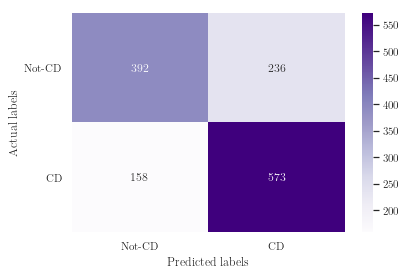

<Figure size 432x288 with 0 Axes>

In [9]:
################ Random Forest ################
# load the results
[label_set, conf, best_score_, best_estimator_, cv_results_, best_params_, predictions]=FileUtility.load_obj('../../crohns_disease/results/RFclassifier/all_results.pickle')

# create the plot (Confusion matrix) and save it in a pdf
create_mat_plot(conf, label_set, '', '../../crohns_disease/results/RFclassifier/confusion_matrix', 'Predicted labels' ,'Actual labels', cmap='Purples', filetype='pdf',font_s=8)

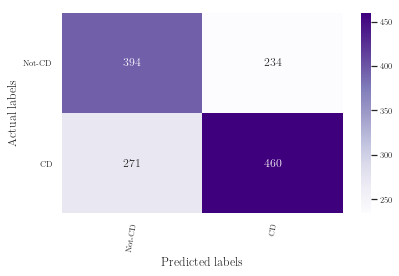

<Figure size 432x288 with 0 Axes>

In [10]:
################ Support Vector Machine ################
[label_set, conf, best_score_, best_estimator_,cv_results_, best_params_, predictions]=FileUtility.load_obj('../../crohns_disease/results/SVMclassifier/all_results.pickle')
create_mat_plot(conf, label_set, '', '../../crohns_disease/results/SVMclassifier/confusion_matrix', 'Predicted labels' ,'Actual labels', cmap='Purples', filetype='pdf', rx=80, ry=0, font_s=8)

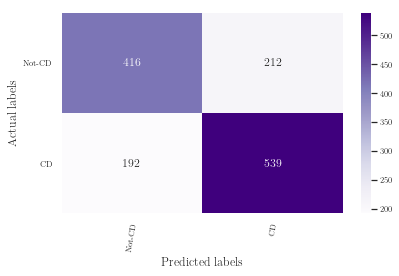

<Figure size 432x288 with 0 Axes>

In [7]:
################ Multilayer Perceptron ################
[label_set, conf, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, accuracy, roc_auc, (loss_values, val_loss_values, epochs)]=FileUtility.load_obj('../../crohns_disease/results/MLPclassifier/results_mlp_1024-0.2-512-0.2-256-0.1-128-8_0.7.pickle')
create_mat_plot(conf, label_set, '', '../../crohns_disease/results/MLPclassifier/confusion_matrix', 'Predicted labels' ,'Actual labels', cmap='Purples', filetype='pdf', rx=80, ry=0, font_s=8)